<a href="https://colab.research.google.com/github/moonjune/test-repo/blob/master/knlp_korean_preproc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/e9t/nsmc.git # 한국 영화 평론 데이터 다운

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 15.67 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [0]:
import os  
os.chdir('/content/nsmc') # 파일 다운 위치
!ls # 존재하는 파일 확인
from google.colab import files #파일 업로드를 위한 라이브러리
files.upload() # 파일 업로드 코드

In [3]:
import os
os.chdir('/content/') # 위치 안꼬이게 하려고
!git clone https://github.com/NLP-kr/tensorflow-ml-nlp.git # NLP를 위한 그거
os.chdir('/content/tensorflow-ml-nlp')
!pip install -r requirements.txt # 저자가 제안하는 패키지 목록

Cloning into 'tensorflow-ml-nlp'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 854 (delta 36), reused 35 (delta 18), pack-reused 778
Receiving objects: 100% (854/854), 160.14 MiB | 23.69 MiB/s, done.
Resolving deltas: 100% (503/503), done.
Checking out files: 100% (100/100), done.
     |████████████████████████████████| 19.4MB 4.9MB/s 
     |████████████████████████████████| 2.7MB 30.7MB/s 


In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

os.chdir('/content/nsmc') # 솔직히 큰 의미는 없어보임

In [5]:
DATA_IN_PATH = '/content/nsmc/' # 데이터가 받아진 장소. 여기 있는 파일들을 쓰겠다고 하는 정도로 사용
print("파일크기: ")
for file in os.listdir(DATA_IN_PATH):
  if 'txt'in file:
   print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file) / 1000000, 2)) + 'MB') # 걍 뭐.. 파일 용량

파일크기: 
ratings_train.txt             14.63MB
ratings_test.txt              4.89MB
ratings.txt                   19.52MB


In [6]:
train_data = pd.read_csv(DATA_IN_PATH + 'ratings_train.txt', header = 0, delimiter = '\t', quoting = 3) # 파일 dataframe으로 가져오기
train_data.head() # 데이터 내용 간략 표시

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
print('전체 학습 데이터의 개수: {}'.format(len(train_data)))

전체 학습 데이터의 개수: 150000


In [8]:
train_length = train_data['document'].astype(str).apply(len) # 각 케이스 별 '한글별 길이' 집계
train_length.head() # 

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

Text(0, 0.5, 'Number of review')

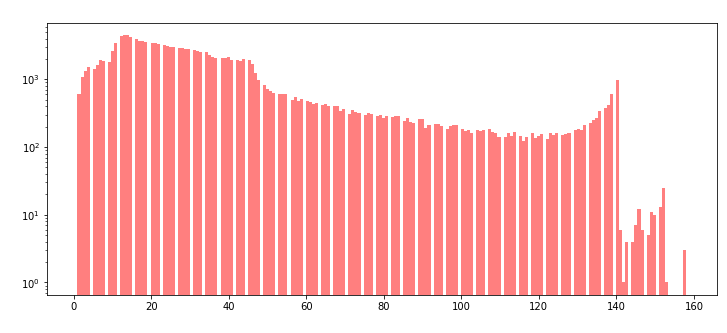

In [9]:
plt.figure(figsize = (12,5)) # 그래프 그리기 
plt.hist(train_length, bins = 200, alpha = 0.5, color = 'r', label = 'word') # 첫번째는 데이터, 두번쨰는 범위 수(1,2,3,4,5 면 5개, 1~10, 11-20, 이러면 2개 등)
plt.yscale('log', nonposy = 'clip') # 스케일은 로그로 
plt.title('Log-Histogram of length of review', color = 'w')
plt.xlabel('Length of review', color = 'w')
plt.ylabel('Number of review', color = 'w')

In [0]:
train_review = [review for review in train_data['document'] if type(review) is str] # str 타입인 리뷰 데이터만 가져오기

In [0]:
wordcloud = WordCloud(font_path = DATA_IN_PATH + 'NanumGothic.ttf').generate(' '.join(train_review)) # 워드 클라우드 그리기.. 

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

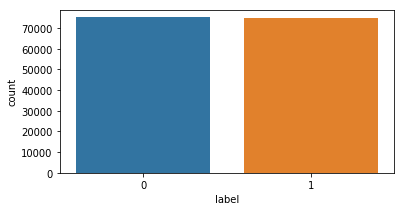

In [11]:
fig, axe = plt.subplots(ncols = 1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['label'])

Text(0, 0.5, 'Num_review')

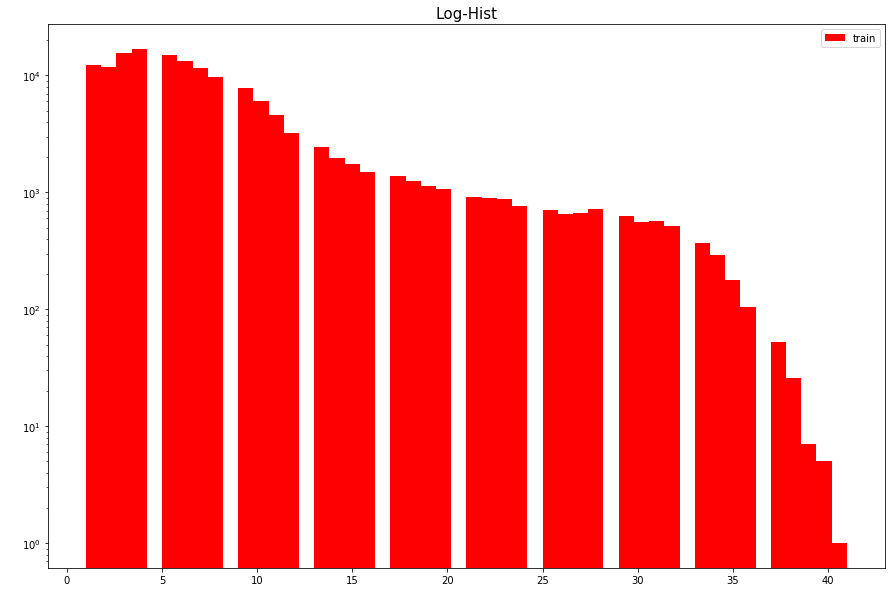

In [12]:
train_word_counts = train_data['document'].astype('str').apply(lambda x: len(x.split(' ')))

plt.figure(figsize = (15, 10))
plt.hist(train_word_counts, bins = 50, facecolor = 'r', label = 'train')
plt.title('Log-Hist', fontsize = 15)
plt.yscale('log', nonposy = 'clip')
plt.legend()
plt.xlabel('Num_word', color = 'w')
plt.ylabel('Num_review', color = 'w')

In [0]:
# 데이터 전처리

import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

DATA_IN_PATH = '/content/nsmc/'

train_data = pd.read_csv(DATA_IN_PATH + 'ratings_train.txt', header = 0, delimiter = '\t', quoting = 3) # 훈련 데이터의 df 화

In [14]:
train_data['document'][0:5] # 아직 정제 안됨

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
Name: document, dtype: object

In [15]:
review_text = re.sub("[^가-힣ㄱ-하-ㅣ\\s]","",train_data['document'][4]) # 정제1: 특수문자를 제외한 한글만 정리 - 이 부분은 추후 고민. 순 한글 외 영문도 필요
print(review_text) # 다만 얘는 아직 전체 정제가 아니라 케이스 하나 시범적으로 한거

사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다


In [16]:
okt = Okt() # OKT는 형태소 분석에 관한 것,  Komoran, Hannanum, Kkma 이 같은 역할을 수행하나 각자 성능이나 형태소 검출 방식이 다름. 여기선 okt로
review_text = okt.morphs(review_text, stem=True) # 정제 2: 한글만 남은 문장을 통과시킴. 그러면 각 어절 별로 기본형으로 변화시킴
print(review_text)

/usr/local/lib/python3.6/dist-packages/jpype/_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


['사이', '몬페', '그', '의', '익살스럽다', '연기', '가', '돋보이다', '영화', '스파이더맨', '에서', '늙다', '보이다', '하다', '커스틴', '던스트', '가', '너무나도', '이쁘다', '보이다']


In [17]:
stop_words = set(['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']) # stop 워드.. 고민이 필요하지만 일단 해당 것들을 제외
clean_review = [token for token in review_text if not token in stop_words] # 
clean_review

['사이',
 '몬페',
 '그',
 '익살스럽다',
 '연기',
 '돋보이다',
 '영화',
 '스파이더맨',
 '에서',
 '늙다',
 '보이다',
 '하다',
 '커스틴',
 '던스트',
 '너무나도',
 '이쁘다',
 '보이다']

In [0]:
def preprocessing(review, okt, remove_stopwords = False, stop_words = []): # 전처리를 위한 함수 정의 
#   함수의 인자는 다음과 같다.
#   review: 전처리할 텍스트
#   okt: okt 객체를 반복적으로 생성하지 않고 미리 생성한 후 인자로 받는다. # 전처리 인자를 정해주는 것이겠지
#   remove_stopword: 불용어를 제거할지 여부 선택
#   stop_word: 불용어 사전은 사용자가 직접 입력해야 함.
#   1. 한글 및 공백을 제외한 문자를 모두 제거
  review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]","",review) # DF로 처리되나보다? 아니더라;;
  
#   2. okt 객체를 이용해 형태소 단위로 나눈다.
  word_review = okt.morphs(review_text, stem= True) # okt를 이용하고 위에서 정제된 review_text를 투입 하는데 stem은 단어에서 어간을 추출함
  
  if remove_stopwords: # 위의 스탑워드 제거가 True라면 아까 위에서 한 스탑워드 제거를 실시
    word_review = [token for token in word_review if not token in stop_words]
  
  return word_review # 그래서 케이스별로 어절이 쪼개진 걸 내보내도록 함. 결과로 나오는 단어는 리스트화 된 문자열임

In [19]:
stop_words = set(['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']) # 미리 스탑워드와
okt = Okt() # 형태소 분석기 Okt를 정의
clean_train_review = [] # 그리고 정제된 데이터를 받을 수 있도록 함..

for review in train_data['document']: # 지금 케이스 한 케이스 집어넣고 있는거임;;;
  # 비어있는 데이터에서 멈추지 않도록 문자열인 경우에만 진행
  if type(review) == str: # 들어간 케이스가 문자열이라면
    clean_train_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words = stop_words)) 
    # 위에서 만든 빈 리스트에 데이터를 넣는데, 걔는 preprocessing을 거쳐서 나온거임
  else:
    clean_train_review.append([]) # string이 아니면 비어있는 값 추가, 순서 맞춰야지

clean_train_review[:4] # 그렇게 맞춘 데이터 형태 탐색

[['더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']]

In [0]:
# clean_train_review_csv = pd.DataFrame(clean_train_review)
# clean_train_review_csv = clean_train_review_csv.to_csv('/content/nsmc/clean_train_review_csv.csv', encoding='ms949') # 얘는 뭐 한글 쓰기 위함

In [21]:
!ls

code		  ratings_train.txt  raw	synopses.json
ratings_test.txt  ratings.txt	     README.md


In [0]:
# from google.colab import files
# files.download('/content/nsmc/clean_train_review_csv.csv') 

In [0]:
test_data = pd.read_csv(DATA_IN_PATH + 'ratings_test.txt',header = 0, delimiter = '\t', quoting = 3) # 테스트 데이터 임포트

clean_test_review = [] # 역시 빈 그거

for review in test_data['document']: 
  # 빈 데이터에서 멈추지 않도록 문자열인 경우만 진행
  if type(review) == str:
    clean_test_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words = stop_words))
  else:
    clean_test_review.append([]) # string이 아니면 비어있는 값 추가 위와 같은 처리

In [24]:
clean_test_review[:10]

[['굳다', 'ㅋ'],
 [],
 ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는'],
 ['만',
  '아니다',
  '별',
  '다섯',
  '개',
  '주다',
  '왜',
  '로',
  '나오다',
  '제',
  '심기',
  '를',
  '불편하다',
  '하다'],
 ['음악', '주가', '되다', '최고', '음악', '영화'],
 ['진정하다', '쓰레기'],
 ['마치',
  '미국',
  '애니',
  '에서',
  '튀어나오다',
  '창의력',
  '없다',
  '로봇',
  '디자인',
  '부터가',
  '고개',
  '를',
  '젖다',
  '하다'],
 ['갈수록',
  '개판',
  '되다',
  '중국영화',
  '유치하다',
  '내용',
  '없다',
  '폼',
  '잡다',
  '끝나다',
  '말',
  '도',
  '안되다',
  '무기',
  '에',
  '유치하다',
  '남무',
  '그리다',
  '동사서독',
  '같다',
  '영화',
  '이건',
  '류',
  '류작',
  '이다'],
 ['이별', '아픔', '뒤', '에', '찾아오다', '새롭다', '인연', '기쁨', '모든', '사람', '그렇다', '않다']]

In [0]:
tokenizer = Tokenizer() # Tokenizer는 keras의 클래스
tokenizer.fit_on_texts(clean_train_review) # 단어들에 대해 index까지만 만들어주는 기능으로 tokenizer는 해당 인덱스를 가지게 됨
train_sequences = tokenizer.texts_to_sequences(clean_train_review) # tokenizer가 가진 인덱스에 맞춰서 시퀀스에 숫자를 넣어 줌 (train)
test_sequences = tokenizer.texts_to_sequences(clean_test_review) # 위랑 같지 뭐(test)

word_vocab = tokenizer.word_index # 얘는 tokenizer가 가지고 있는 word_index dict(단어:인덱스)를 복사해주는 것

MAX_SEQUENCE_LENGTH = 8 # 이건 통계적으로 따왔다고 함. 나중에 이걸 20단어 이렇게 가야하려나... 

train_inputs = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post') 
# 패딩함. 8개 단어 자리를 생성하고 리뷰가 8개 단어 이하면 모자란 자리는 0을 넣어준다.얘는 input이고 
train_labels = np.array(train_data['label'])
# 얘는 감정 그거를 만들어 줌 

test_inputs = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
test_labels = np.array(test_data['label'])
# 위랑 같음 ㅇㅇ

In [43]:
type(word_vocab)

dict

In [0]:
# 전처림 저장하기
DATA_IN_PATH = '/content/nsmc/'
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'  # npy는 무엇일까...
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_configs.json'

data_configs = {} # 사전형 자료 

data_configs['vocab'] = word_vocab # 단어로는 위에서 뽑은 
data_configs['vocab_size'] = len(word_vocab)+1  
#전체 단어 인덱스들이 하나의 vocab 값이고, vocab_size는 전체 수가 된다. 이것의 의미를 알아보는게 필요

import os
if not os.path.exists(DATA_IN_PATH):
  os.makedirs(DTA_IN_PATH)

np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_LABEL_DATA, 'wb'), test_labels)

json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii = False)

In [0]:
# cnn 방법을 적용할 예정
import os
from datetime import datetime
import tensorflow as tf
import numpy as np
import json
from sklearn.model_selection import train_test_split

In [0]:
DATA_IN_PATH = '/content/nsmc/'
DATA_OUT_PATH = '/content/nsmc/data_out/'
INPUT_TRAIN_DATA_FILE_NAME = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA_FILE_NAME = 'nsmc_train_label.npy'
DATA_CONFIGS_FILE_NAME = 'data_configs.json'

input_data = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA_FILE_NAME, 'rb'))
label_data = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA_FILE_NAME, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS_FILE_NAME, 'r'))

In [0]:
TEST_SPLIT = 0.1
RNG_SEED = 13371447
VOCAB_SIZE = prepro_configs['vocab_size']
EMB_SIZE = 128
BATCH_SIZE = 16
NUM_EPOCHS = 1

input_train, input_eval, label_train, label_eval = train_test_split(input_data, label_data, test_size = TEST_SPLIT, random_state = RNG_SEED)

In [0]:
def mapping_fn(X, Y):
  input, label = {'x': X}, Y
  return input, label

def train_input_fn():
  dataset = tf.data.Dataset.from_tensor_slices((input_train, label_train))
  dataset = dataset.shuffle(buffer_size = len(input_train))
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.map(mapping_fn)
  dataset = dataset.repeat(count=NUM_EPOCHS)
  iterator = dataset.make_one_shot_iterator()
  
  return iterator.get_next()

def eval_input_fn():
  dataset = tf.data.Dataset.from_tensor_slices((input_eval, label_eval))
  dataset = dataset.shuffle(buffer_size = len(input_eval))
  dataset = dataset.batch(16)
  dataset = dataset.map(mapping_fn)
  iterator = dataset.make_one_shot_iterator()

  return iterator.get_next()

In [0]:
def model_fn(features, labels, mode, params):
    TRAIN = mode == tf.estimator.ModeKeys.TRAIN
    EVAL = mode == tf.estimator.ModeKeys.EVAL
    PREDICT = mode == tf.estimator.ModeKeys.PREDICT

    embedding_layer = tf.keras.layers.Embedding(
                    VOCAB_SIZE,
                    EMB_SIZE)(features['x'])

    dropout_emb = tf.keras.layers.Dropout(rate = 0.2)(embedding_layer)
    
    conv = tf.keras.layers.Conv1D(
           filters=32,
           kernel_size=3,
           padding='same',
           activation=tf.nn.relu)(dropout_emb)
  
    pool = tf.keras.layers.GlobalMaxPool1D()(conv)

    hidden = tf.keras.layers.Dense(units=250, activation=tf.nn.relu)(pool)   


    dropout_hidden = tf.keras.layers.Dropout(rate=0.2)(hidden, training = TRAIN)
    logits = tf.keras.layers.Dense(units=1)(dropout_hidden)

    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])
        
    if TRAIN:
        global_step = tf.train.get_global_step()
        loss = tf.losses.sigmoid_cross_entropy(labels, logits)
        train_op = tf.train.AdamOptimizer(0.001).minimize(loss, global_step)

        return tf.estimator.EstimatorSpec(mode=mode, train_op=train_op, loss = loss)
    
    elif EVAL:
        loss = tf.losses.sigmoid_cross_entropy(labels, logits)
        pred = tf.nn.sigmoid(logits)
        accuracy = tf.metrics.accuracy(labels, tf.round(pred))
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops={'acc': accuracy})
        
    elif PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions={
                'prob': tf.nn.sigmoid(logits),
            }
        )

In [32]:
est = tf.estimator.Estimator(model_fn, model_dir="data_out/checkpoint/cnn_model")

W0701 14:27:43.897473 140065188849536 model_fn.py:630] Estimator's model_fn (<function model_fn at 0x7f6330ea58c8>) includes params argument, but params are not passed to Estimator.


In [33]:
time_start = datetime.utcnow()
print("Experiment started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................") 

est.train(train_input_fn)

time_end = datetime.utcnow()
print(".......................................")
print("Experiment finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Experiment elapsed time: {} seconds".format(time_elapsed.total_seconds()))

W0701 14:27:43.973913 140065188849536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0701 14:27:44.057198 140065188849536 deprecation.py:323] From <ipython-input-30-e49c750a96a2>:11: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


Experiment started at 14:27:43
.......................................


W0701 14:27:44.156023 140065188849536 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0701 14:27:44.203948 140065188849536 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0701 14:27:44.329153 140065188849536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.o

.......................................
Experiment finished at 14:36:17

Experiment elapsed time: 513.563402 seconds


In [34]:
valid = est.evaluate(eval_input_fn)

W0701 14:36:17.840692 140065188849536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [0]:
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'

test_input_data = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

In [0]:
def test_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((test_input_data, test_label_data))
    dataset = dataset.batch(16)
    dataset = dataset.map(mapping_fn)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

In [0]:
predict = est.evaluate(test_input_fn)

In [38]:
type(predict)

dict

In [39]:
predict

{'acc': 0.82404, 'global_step': 8438, 'loss': 0.38570532}

In [40]:
!ls

code		     nsmc_test_label.npy   ratings_train.txt  synopses.json
data_configs.json    nsmc_train_input.npy  ratings.txt
data_out	     nsmc_train_label.npy  raw
nsmc_test_input.npy  ratings_test.txt	   README.md


In [41]:
test_input_data = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))  # 테스트 데이터 설정
ids = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb')) # 위에서 ID 데이터란걸 만들었네... 

predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x":test_input_data}, shuffle=False)

predictions = np.array([p['prob'] for p in cnn_est.predict(input_fn=predict_input_fn)])

NameError: ignored